## Подготовка данных

In [1]:
#  Загружаем библиотеки
import numpy as np # linear algebra
import pandas as pd
import os
import requests  
from bs4 import BeautifulSoup
import time
import json
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm
from sklearn.ensemble import StackingRegressor
# import xgboost as xgb

In [2]:
# Определение метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [3]:
# Загрузим тестовую выборку
train = pd.read_csv('auto_df.csv')

In [4]:
train = train.drop('Unnamed: 0', axis=1)
train.head(5)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,advert_date,price
0,внедорожник 5 дв.,HONDA,белый,"['cruise-control', 'multi-wheel', 'airbag-pass...","КОМПЛЕКТ ЗИМНЕЙ РЕЗИНЫ НА ЛИТЫХ ДИСКАХ, БЫСТРО...",3.5 LTR,249 N12,"{'cruise-control': True, 'esp': True, 'multi-w...",бензин,108600,...,JAPANESE,1 владелец,9 лет и 3 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,18 сентября,1799000.0
1,внедорожник 5 дв.,HONDA,серый,"['cruise-control', 'multi-wheel', 'xenon', 'ai...",Действительно честный Honda Crosstour в отл...,3.5 LTR,275 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,123000,...,JAPANESE,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,17 сентября,1255000.0
2,внедорожник 5 дв.,HONDA,серый,"['cruise-control', 'multi-wheel', 'xenon', 'ai...",Крос в отличном состоянии!купил неделю назад ж...,3.5 LTR,275 N12,{},бензин,138500,...,JAPANESE,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,23 июля,1170000.0
3,внедорожник 5 дв.,HONDA,чёрный,"['cruise-control', 'multi-wheel', 'airbag-pass...","Преимущества автомобиля:\n\n∙ ПТС Оригинал,...",2.4 LTR,190 N12,"{'cruise-control': True, 'esp': True, 'airbag-...",бензин,177362,...,JAPANESE,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,19 сентября,1579000.0
4,внедорожник 5 дв.,HONDA,белый,"['cruise-control', 'xenon', 'airbag-passenger'...",При покупке автомобиля до 27 сентября: \n► В...,2.4 LTR,166 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,202584,...,JAPANESE,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,19 сентября,1237000.0


In [5]:
test = pd.read_csv('test.csv')

In [6]:
# Заменим названия колонок
train.rename(columns={'bodyType': 'body_type',
                     'modelDate': 'model_date',
                     'engineDisplacement': 'engine_displacement',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel_type',
                     'numberOfDoors': 'number_of_doors',
                     'priceCurrency': 'price_currency',
                     'productionDate': 'production_date',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'vehicle_transmission',
                     'Владельцы': 'owners',
                     'Владение': 'ownership',
                     'ПТС': 'documents',
                     'Привод': 'drive',
                     'Руль': 'drive_side',
                     'Состояние': 'condition',
                     'Таможня': 'customs'}, inplace=True)

In [7]:
# Заменим названия колонок
test.rename(columns={'bodyType': 'body_type',
                     'modelDate': 'model_date',
                     'engineDisplacement': 'engine_displacement',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel_type',
                     'numberOfDoors': 'number_of_doors',
                     'priceCurrency': 'price_currency',
                     'productionDate': 'production_date',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'vehicle_transmission',
                     'Владельцы': 'owners',
                     'Владение': 'ownership',
                     'ПТС': 'documents',
                     'Привод': 'drive',
                     'Руль': 'drive_side',
                     'Состояние': 'condition',
                     'Таможня': 'customs'}, inplace=True)

### Вопрос инфляции

In [8]:
# Добавляем колонку из тестовой выборки parsing_unixtime
test['parsing_date'] = pd.to_datetime(test.parsing_unixtime, unit='s')
test['parsing_date'] = pd.to_datetime(test['parsing_date']).dt.floor('d')
test.parsing_date

0       2020-10-20
1       2020-10-20
2       2020-10-20
3       2020-10-20
4       2020-10-20
           ...    
34681   2020-10-26
34682   2020-10-26
34683   2020-10-26
34684   2020-10-26
34685   2020-10-26
Name: parsing_date, Length: 34686, dtype: datetime64[ns]

Можно заметить, что парсинг для тестовой выборки осуществлялся в октябре 2020 года. Это имеет значение для корректы цен по сравнению с актуальными. Признак больше не нужен, использоваться для дальнейшего анализа не будет

In [9]:
# Загрузим доступный на kaggle.com файл, соотетсвующий уровню цен сентября 2020
train_2020 = pd.read_csv('all_auto_ru_09_09_2020.csv')

In [10]:
# средние цены 2021
display(train.price.head(7))

0    1799000.0
1    1255000.0
2    1170000.0
3    1579000.0
4    1237000.0
5    1420000.0
6     450000.0
Name: price, dtype: float64

In [11]:
brands = train_2020.brand.unique()

In [12]:
for brand in brands:
    mean20 = train_2020[train_2020["brand"]==brand].price.mean()
    
    mean21 = train[train["brand"]==brand].price.mean()
    inf = (mean21 - mean20)/mean20
    if inf > 0:
        train.loc[train["brand"]==brand, ['price']] = train.loc[train["brand"]==brand, ['price']].apply(lambda x: round(x / (1+inf),0))
display(train.price.head(7))

0    1394146.0
1     972570.0
2     906699.0
3    1223656.0
4     958621.0
5    1100438.0
6     348730.0
Name: price, dtype: float64

In [13]:
test['price'] = 0
df_train = train
df_test = test

# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.head(5)

,body_type,brand,car_url,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,...,ownership,documents,drive,drive_side,condition,customs,parsing_date,price,sample,advert_date
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2020-10-20,0.0,0,NaN
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2020-10-20,0.0,0,NaN
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2020-10-20,0.0,0,NaN
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2020-10-20,0.0,0,NaN
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2020-10-20,0.0,0,NaN


## Создание наивной / ленивой модели

In [15]:
train_na = train.copy()

In [16]:
# Просто удалим пропуски 
train_na.dropna(inplace=True)

In [17]:
train_na.columns

Index(['body_type', 'brand', 'color', 'complectation_dict', 'description',
       'engine_displacement', 'engine_power', 'equipment_dict', 'fuel_type',
       'mileage', 'model_date', 'model_info', 'model_name', 'name',
       'number_of_doors', 'parsing_unixtime', 'production_date', 'sell_id',
       'super_gen', 'vehicle_configuration', 'vehicle_transmission', 'vendor',
       'owners', 'ownership', 'documents', 'drive', 'drive_side', 'condition',
       'customs', 'advert_date', 'price', 'sample'],
      dtype='object')

In [18]:
bin_cols = ['customs', 'documents','drive','condition']

cat_cols = ['body_type', 'brand', 'color','complectation_dict','description',
            'engine_displacement', 'engine_power', 'equipment_dict','fuel_type','model_info',
           'model_name', 'name','super_gen','vehicle_configuration','vehicle_transmission',
           'vendor', 'owners', 'ownership','drive']

num_cols = ['mileage', 'model_date', 'number_of_doors', 'parsing_unixtime', 
            'production_date','sell_id']

In [19]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    train_na[column] = label_encoder.fit_transform(train_na[column])

In [20]:
train_na[bin_cols]

,customs,documents,drive,condition
0,0,1,2,0
5,0,1,2,0
14,0,1,1,0
15,0,1,1,0
16,0,1,1,0
...,...,...,...,...
25018,0,1,0,0
25019,0,1,2,0
25020,0,1,0,0
25021,0,1,2,0


In [21]:
# Для категориальных признаков мы тоже будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in cat_cols:
    train_na[column] = label_encoder.fit_transform(train_na[column])

In [22]:
train_na[cat_cols]

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,model_info,model_name,name,super_gen,vehicle_configuration,vehicle_transmission,vendor,owners,ownership,drive
0,1,2,1,311,3481,28,123,2484,0,450,262,526,7675,33,0,2,0,253,2
5,1,2,1,449,6143,13,46,1919,0,188,80,479,2554,21,0,2,0,246,2
14,13,2,11,1382,6632,17,81,2466,0,92,45,461,6465,396,2,2,2,208,1
15,5,2,13,1382,7664,8,65,1126,0,157,101,497,2588,176,1,2,0,133,1
16,13,2,1,1382,5183,17,87,3168,0,92,45,463,6564,359,0,2,2,254,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25018,13,1,13,1318,3959,8,33,6707,0,23,11,137,2669,352,0,1,0,126,0
25019,13,1,13,669,3160,13,101,3300,3,42,18,217,237,355,0,1,2,11,2
25020,17,1,15,1382,7900,13,57,6038,3,26,11,140,1321,448,0,1,2,12,0
25021,13,1,11,317,4096,13,101,3262,3,42,18,216,835,355,0,1,2,193,2


In [23]:
# Помещаем данные по типу в матрицу переменных
X_num_na = train_na[num_cols].values
X_bin_na = train_na[bin_cols].values
X_cat_na = train_na[cat_cols].values

# Объединяем три типа данных в одну матрицу значений Х
X_na = np.hstack([X_num_na, X_bin_na, X_cat_na,])
y_na = train_na['price'].values

# Разделим данные для обучения
X_train, X_val, y_train, y_val = train_test_split(X_na, y_na, test_size=0.20, random_state=42)

# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказываем на валидационной выборке
y_pred_val = model.predict(X_val)

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_val, y_pred_val))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 119.23%


Это отправная точка для усовершенствования предсказаний.

## Преобразования

In [24]:
# Функция, присвающая выбросам значения в межквартильном пределе  
def cut_IQR(column, data):
    Q25 = data[column].quantile(0.25)
    Q75 = data[column].quantile(0.75)
    IQR = Q75 - Q25
    l_bound = Q25 - 1.5*IQR
    r_bound = Q75 + 1.5*IQR

    data[column] = data[column].apply(lambda x: r_bound if x  >=  r_bound else x)
    data[column] = data[column].apply(lambda x: l_bound if x  <=  l_bound else x)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59717 entries, 0 to 59716
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   body_type              59717 non-null  object        
 1   brand                  59717 non-null  object        
 2   car_url                34686 non-null  object        
 3   color                  59717 non-null  object        
 4   complectation_dict     31449 non-null  object        
 5   description            59717 non-null  object        
 6   engine_displacement    59717 non-null  object        
 7   engine_power           59717 non-null  object        
 8   equipment_dict         49721 non-null  object        
 9   fuel_type              59717 non-null  object        
 10  image                  34686 non-null  object        
 11  mileage                59717 non-null  int64         
 12  model_date             59717 non-null  float64       
 13  m

### Категориальные признаки

В датасете присутствует большое значение категориальных признаков, из которых стоит извлечь числовые. Остальные можно преобразовать в ординарные или бинарные.

#### *Тип кузова*

In [31]:
data.body_type.value_counts()

внедорожник 5 дв.          21875
седан                      21689
лифтбек                     4061
хэтчбек 5 дв.               3470
универсал 5 дв.             2226
минивэн                     1739
купе                        1479
хэтчбек 3 дв.                844
компактвэн                   782
пикап двойная кабина         478
купе-хардтоп                 230
фургон                       202
внедорожник 3 дв.            188
родстер                      182
кабриолет                    175
седан-хардтоп                 27
микровэн                      20
пикап одинарная кабина        15
седан 2 дв.                   10
пикап полуторная кабина        9
лимузин                        8
внедорожник открытый           4
тарга                          3
фастбек                        1
Name: body_type, dtype: int64

In [32]:
# Удаляем значения более одного слова
data['body_type'] = data['body_type'].astype(str).apply(lambda x: None if x.strip() == '' else x)
data['body_type'] = data['body_type'].apply(lambda x: x.split(' ')[0])
data['body_type'].value_counts()

внедорожник      22067
седан            21699
хэтчбек           4314
лифтбек           4061
универсал         2226
минивэн           1739
купе              1479
компактвэн         782
пикап              502
купе-хардтоп       230
фургон             202
родстер            182
кабриолет          175
седан-хардтоп       27
микровэн            20
лимузин              8
тарга                3
фастбек              1
Name: body_type, dtype: int64

In [33]:
# Удаляем дополнительные параметры (хардтоп), которые указаны через дефис
data['body_type'] = data['body_type'].astype(str).apply(lambda x: None if x.strip() == '-' else x)
data['body_type'] = data['body_type'].apply(lambda x: x.split('-')[0])

In [34]:
data['body_type'].value_counts()

внедорожник    22067
седан          21726
хэтчбек         4314
лифтбек         4061
универсал       2226
минивэн         1739
купе            1709
компактвэн       782
пикап            502
фургон           202
родстер          182
кабриолет        175
микровэн          20
лимузин            8
тарга              3
фастбек            1
Name: body_type, dtype: int64

#### *Пакеты - complectation_dict*

In [35]:
data.complectation_dict.isna().value_counts()

False    31449
True     28268
Name: complectation_dict, dtype: int64

In [36]:
# В собранном мною датасете нет пропусков, однако в тестовой выборке есть только около 22% данных
test.complectation_dict.isna().value_counts()

True     28268
False     6418
Name: complectation_dict, dtype: int64

In [37]:
# пример содержания информации о пакете
data.complectation_dict[47080]

"['airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'climate-control-1', 'esp', 'audiopreparation', 'electro-window-back', 'condition', 'music-super', 'airbag-driver', 'electro-window-front', 'ptf', 'audiosystem-cd', 'migration-flag', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', 'immo']"

Наличие информации о пакете комплектации может влиять на цену автомобиля, но в данном признаке слишком много пропусков, поэтому  на данном этапе решение - не принимать во внимание для дальнешего анализа

In [38]:
# data['complectation_dict'].fillna(0, inplace=True)
# data['complectation_dict'].isna().value_counts()
# data['complectation_dict'] = data['complectation_dict'].apply(lambda x: len(x))

In [39]:
# # Проверим правильность
# data.complectation_dict.value_counts()

#### *Описание - decription*

In [40]:
# Пример описания в объявлении
data['description'][0]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

In [41]:
# можно посчитать длину комментария и создать из этого числовой признак
data['description_len'] = data.description.apply(lambda x: len(str(x)))

#### * Объем двигателя - Engine Displacement*

In [42]:
# Посмотрим на уникальные значения и их количество
data['engine_displacement'].value_counts()

2.0 LTR    13501
1.6 LTR     8375
3.0 LTR     7083
1.8 LTR     5334
2.5 LTR     4129
1.4 LTR     3006
2.4 LTR     2802
3.5 LTR     2715
1.5 LTR     1174
1.2 LTR      779
4.4 LTR      751
2.8 LTR      696
4.5 LTR      683
1.3 LTR      664
4.0 LTR      664
4.7 LTR      656
5.5 LTR      609
2.1 LTR      530
3.2 LTR      524
4.2 LTR      387
2.2 LTR      383
2.7 LTR      374
1.9 LTR      332
2.3 LTR      325
3.6 LTR      311
5.7 LTR      310
3.7 LTR      286
2.9 LTR      258
4.6 LTR      240
5.0 LTR      230
5.6 LTR      228
3.1 LTR      130
4.8 LTR      116
 LTR         113
1.0 LTR      111
0.7 LTR       98
3.8 LTR       96
1.7 LTR       94
2.6 LTR       91
6.0 LTR       80
3.3 LTR       75
3.4 LTR       63
6.2 LTR       63
4.1 LTR       60
5.4 LTR       56
4.3 LTR       49
5.2 LTR       17
5.9 LTR       17
6.3 LTR       12
5.8 LTR       11
6.6 LTR        8
4.9 LTR        8
1.1 LTR        6
3.9 LTR        2
0.6 LTR        1
5.3 LTR        1
Name: engine_displacement, dtype: int64

In [43]:
# Удалим обознаяение литра
data['engine_displacement'] = data['engine_displacement'].apply(lambda x: x[:3])
# Заменим в значениях, где не было числа на 1.0. Возможно, кто-то ошибочно указал LTR
data['engine_displacement'] = data['engine_displacement'].replace(' LT','1.0')
# Заменим значения на числовые 
data['engine_displacement'] = data['engine_displacement'].apply(lambda x: float(x))

In [44]:
data['engine_displacement'].value_counts()

2.0    13501
1.6     8375
3.0     7083
1.8     5334
2.5     4129
1.4     3006
2.4     2802
3.5     2715
1.5     1174
1.2      779
4.4      751
2.8      696
4.5      683
1.3      664
4.0      664
4.7      656
5.5      609
2.1      530
3.2      524
4.2      387
2.2      383
2.7      374
1.9      332
2.3      325
3.6      311
5.7      310
3.7      286
2.9      258
4.6      240
5.0      230
5.6      228
1.0      224
3.1      130
4.8      116
0.7       98
3.8       96
1.7       94
2.6       91
6.0       80
3.3       75
3.4       63
6.2       63
4.1       60
5.4       56
4.3       49
5.9       17
5.2       17
6.3       12
5.8       11
4.9        8
6.6        8
1.1        6
3.9        2
0.6        1
5.3        1
Name: engine_displacement, dtype: int64

Этот признак преобразован в числовой

#### * Мощность двигателя - Engine Power*

In [45]:
data['engine_power'].value_counts()

249 N12    3541
150 N12    3327
110 N12    2012
184 N12    1669
170 N12    1639
           ... 
402 N12       1
338 N12       1
254 N12       1
32 N12        1
514 N12       1
Name: engine_power, Length: 333, dtype: int64

In [46]:
# Удалим обозначение N12
data['engine_power'] = data['engine_power'].apply(lambda x: x[:3])
data['engine_power'] = data['engine_power'].apply(lambda x: int(x))

In [47]:
data['engine_power'].value_counts()

249    3541
150    3327
110    2012
184    1669
170    1639
       ... 
338       1
402       1
19        1
344       1
32        1
Name: engine_power, Length: 333, dtype: int64

Этот признак преобразован в числовой

#### *Элементы комплектации  - equipment_dict*

In [48]:
# Посмотрим на количество пропусков в тестовой выборке
test['equipment_dict'].isna().value_counts()

False    24690
True      9996
Name: equipment_dict, dtype: int64

In [49]:
test['equipment_dict'][0]

'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

Поскольку пропусков слишком много, на данном этапе решаю не использовать признак для дальнейшего анализа

In [50]:
# data['equipment_dict'].fillna(0, inplace=True)
# data['equipment_dict'].isna().value_counts()
# data['equipment_dict'] = data['equipment_dict'].apply(lambda x: len(x))

In [51]:
# # Проверяем результат
# data['equipment_dict'].value_counts()

#### *Model Info*

In [52]:
# Пример содержания ModelInfo
data['model_info'][3900]

'{"code":"A6","name":"A6","ru_name":"А6","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

Я потратил много времени на поиск этого признака, но нет в нем ничего, что можно было бы использовать. Этот признак не будет использоваться для прогнозирования цены

#### *Name*

In [53]:
data['name'].value_counts()

1.6 AT (110 л.с.)                                     631
1.6 MT (102 л.с.)                                     410
Volkswagen Polo V Рестайлинг                          373
1.6 MT (110 л.с.)                                     314
2.0 CVT (141 л.с.) 4WD                                309
                                                     ... 
BMW 7 серии 750d xDrive V (F01/F02/F04) Рестайлинг      1
Toyota Camry US Market VIII (XV70)                      1
Mercedes-Benz E-Класс 430 II (W210, S210)               1
4-Seater 3.6 AT (280 л.с.) 4WD                          1
2.0 MT (121 л.с.)                                       1
Name: name, Length: 5109, dtype: int64

Признак name содержит информацию об объеме двигателя, а также мощности. Эта информация есть в других признаках. Признак не будет использован для дальнейшей переработки

#### *Super_gen*

In [54]:
# Посмотрим, что содержит признак
data['super_gen'][0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

Признак super_gen из парсинга отличается по содержанию от тестовой выборки, поэтому не может использоваться для дальнейшего анализа

#### *Конфигурация транспортного средства - vehicle configuration*

In [55]:
data['vehicle_configuration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0      4376
SEDAN AUTOMATIC 2.0                2894
ALLROAD_5_DOORS AUTOMATIC 2.0      2657
ALLROAD_5_DOORS VARIATOR 2.0       2320
SEDAN MECHANICAL 1.6               2085
                                   ... 
PICKUP_TWO AUTOMATIC 4.6              1
CABRIO MECHANICAL 5.3                 1
COUPE ROBOT 3.3                       1
CABRIO AUTOMATIC 3.5                  1
HATCHBACK_5_DOORS AUTOMATIC 2.4       1
Name: vehicle_configuration, Length: 697, dtype: int64

Признак содержит данные, которые имеются в других признаках: тип кузова, количество дверей, тип коробки передач. Признак не будет учитываться

#### *Владельцы - owners*

In [56]:
data['owners'].value_counts()

3 или более    26834
1 владелец      9459
2 владельца     9270
1 владелец      7556
2 владельца     6597
Name: owners, dtype: int64

In [57]:
type(data.owners[0])

str

In [58]:
# Переведем значения в числовые
data['owners'] = data['owners'].apply(lambda x: int(x[0]) if type(x) == str else x)

In [59]:
data['owners'].value_counts()

3.0    26834
1.0    17015
2.0    15867
Name: owners, dtype: int64

In [60]:
data.owners.fillna(3.0, inplace=True)

#### *Vendor*

In [130]:
# Заполним пропуски наиболее частым значением
data.vendor.fillna('EUROPEAN', inplace=True)

#### *Владение - ownership*

In [61]:
data['ownership'].value_counts()

1 год и 1 месяц         363
11 месяцев              349
1 год                   347
10 месяцев              323
9 месяцев               320
                       ... 
23 года и 10 месяцев      1
22 года и 4 месяца        1
18 лет и 4 месяца         1
30 лет и 7 месяцев        1
31 год и 5 месяцев        1
Name: ownership, Length: 301, dtype: int64

In [62]:
# отсутствует слишком большое количество значений
data['ownership'].isna().value_counts()

True     39708
False    20009
Name: ownership, dtype: int64

Признак не будет использоваться для дальнейшего анализа

Следующие признаки не содержат пропусков, будет трансформированы в ординальные:

* bodyType
* brand
* color
* fuel_type
* model_name
* vehicleTransmission
* vendor

### *Выводы по категориальным признакам*
Несколько признаков были преобразовано в числовые:
* engineDisplacement
* enginePower
* description_len
* Владельцы

Следующие признаки будут конвертироваться в ординальные:
* bodyType
* brand
* color
* fuel_type
* model_name
* vehicleTransformation
* vendor
* Привод


Следующие признаки не будут использоваться в дальнейшем анализе:
* model_info
* name
* vehicleConfiguration

In [63]:
# Обновленный список разделения признаков
bin_cols = ['customs', 'documents','drive_side','condition', 'complectation_dict', 'equipment_dict']

cat_cols = ['body_type', 'brand', 'color',
            'fuel_type',
           'model_name','vehicle_transmission',
           'vendor', 'drive']

num_cols = ['mileage', 'model_date', 'number_of_doors', 
            'production_date','description_len', 'engine_displacement',
            'owners', 'engine_power']

In [64]:
# Количество названий моделей очень велико, поэтому исключим из списка
cat_cols_no_model = ['body_type', 'brand', 'color',
            'fuel_type',
           'vehicle_transmission',
           'vendor', 'drive']

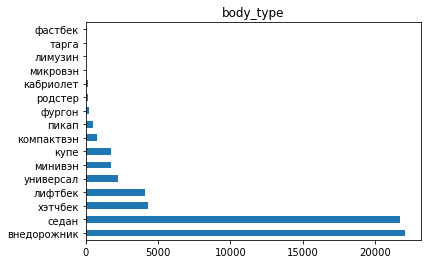

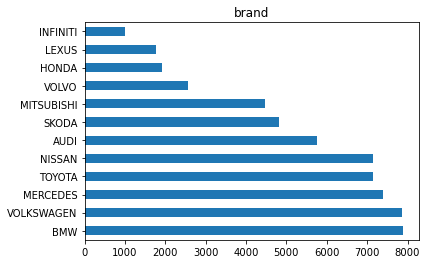

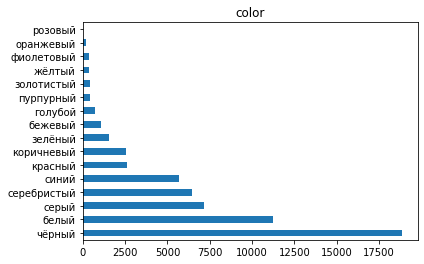

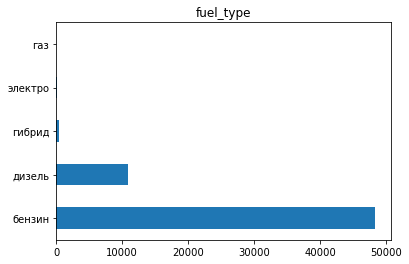

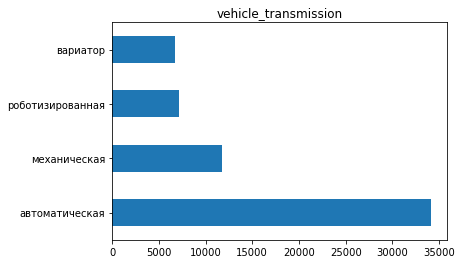

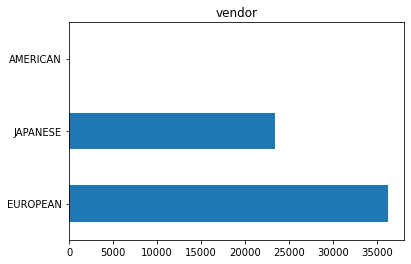

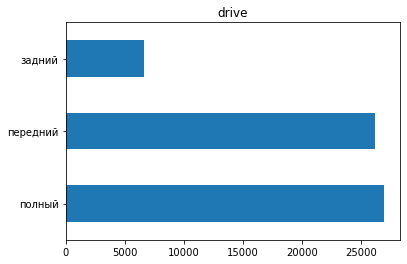

In [65]:
# Посмотрим на распределение категориальных признаков
for i in cat_cols_no_model:
#     plt.figure()
    data[i].value_counts().plot.barh()
    plt.title(i)
    plt.show()

Это показатели присутствия данных значений в приготовленной выборке. В цвете доминирует черный, белый на втором.Среди лидеров кузова седан и внедорожник. Большнство представленных авто заправляется бензином. Автоматическая коробка передач является лидером. 

In [66]:
# Преобразуем категориальные признаки в ординальные
label_encoder = LabelEncoder()
for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [129]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59712 entries, 0 to 59716
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   body_type             59712 non-null  int64
 1   brand                 59712 non-null  int64
 2   color                 59712 non-null  int64
 3   fuel_type             59712 non-null  int64
 4   model_name            59712 non-null  int64
 5   vehicle_transmission  59712 non-null  int64
 6   vendor                59712 non-null  int64
 7   drive                 59712 non-null  int64
dtypes: int64(8)
memory usage: 6.1 MB


### Целевая переменная - цена

<Figure size 432x288 with 0 Axes>

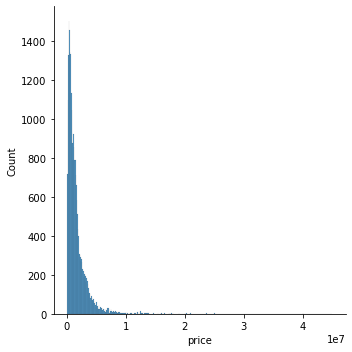

In [67]:
# Посмотрим еа распределение цены
plt.figure()
# plt.title(f"Распределение {'price'}")
sns.displot(train.price, kde=False)

Видна большая диспропорция. Возможно логарифирмирование решит проблему

### Числовые признаки

In [68]:
data[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59717 entries, 0 to 59716
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mileage              59717 non-null  int64  
 1   model_date           59717 non-null  float64
 2   number_of_doors      59717 non-null  float64
 3   production_date      59717 non-null  float64
 4   description_len      59717 non-null  int64  
 5   engine_displacement  59717 non-null  float64
 6   owners               59717 non-null  float64
 7   engine_power         59717 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 3.6 MB


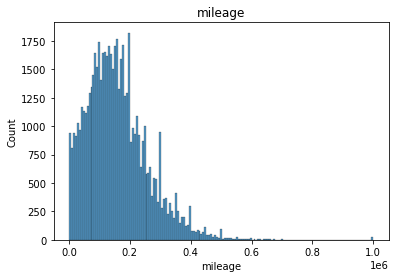

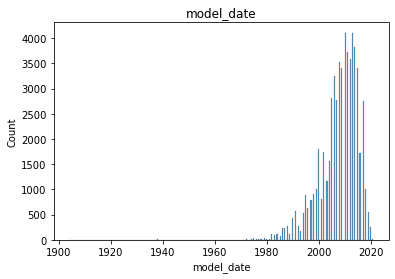

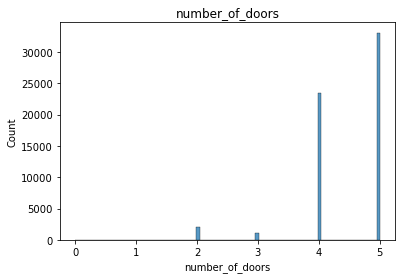

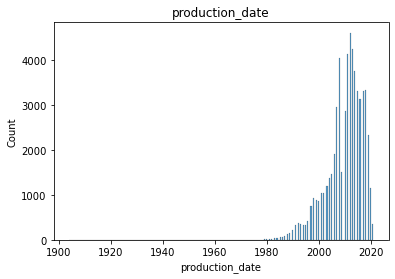

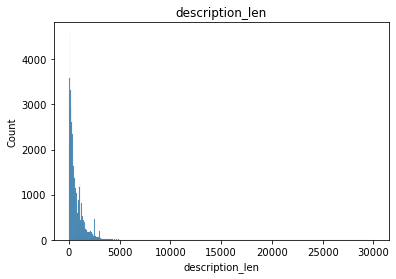

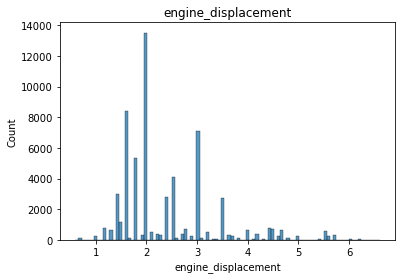

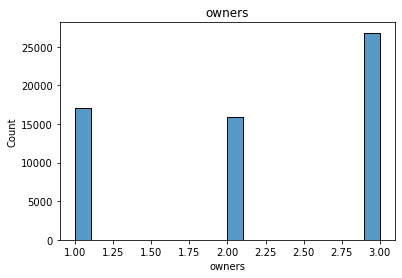

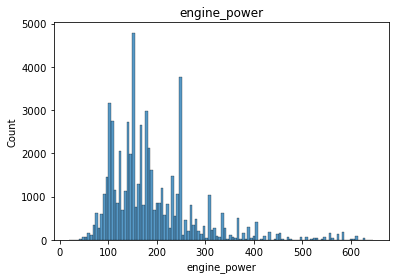

In [69]:
# Посмотрим на графики перед преобразованиями
for i in num_cols:
    plt.figure()
    sns.histplot(data[i], kde = False,)
    plt.title(i)
    plt.show()

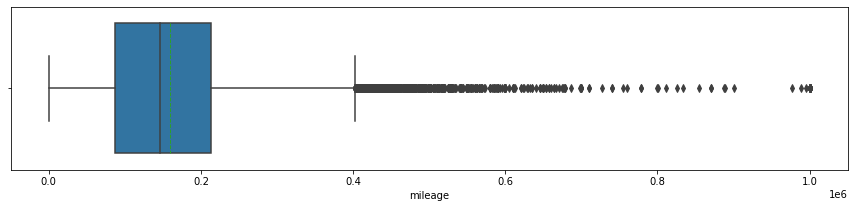

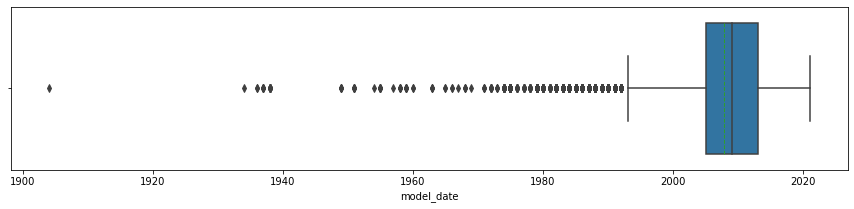

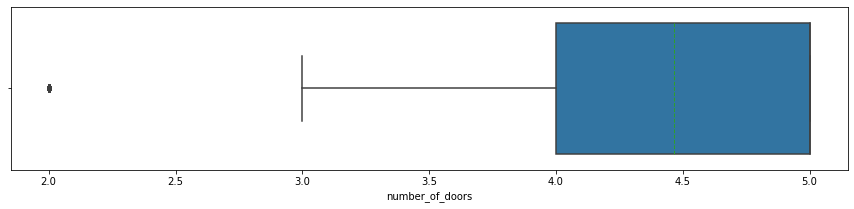

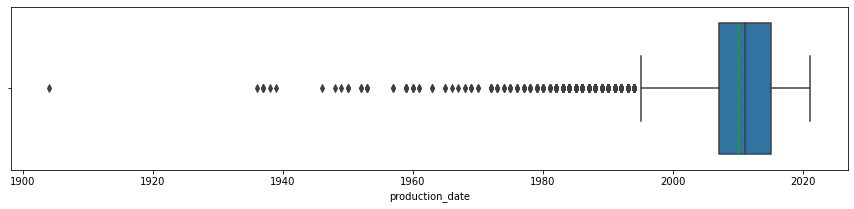

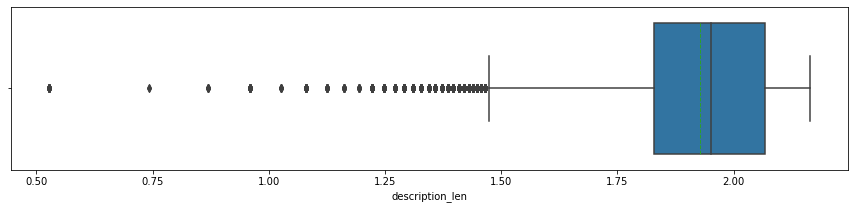

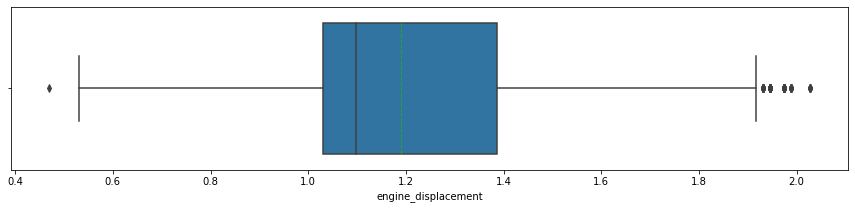

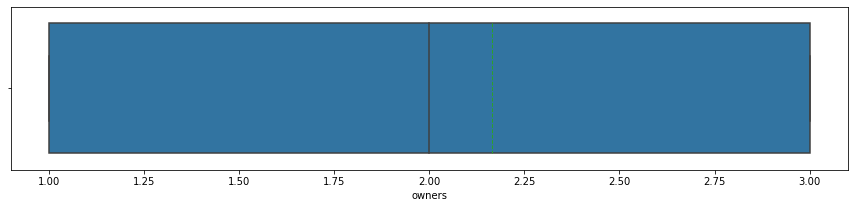

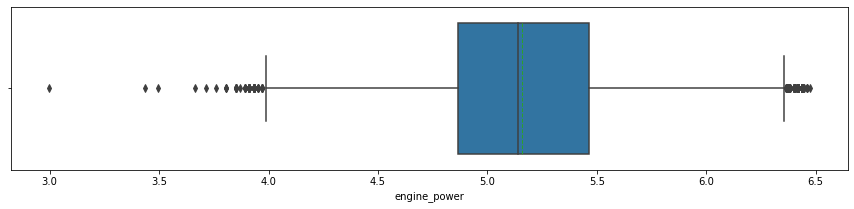

In [126]:
# Графики boxplot перед преобразованиями
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(x = data[col],showmeans=True, meanline=True, orient='h')


Есть смещение в большинстве признаков, распределение отсносительно нормальное. Нет большой разницы значений, а смещение может влиять на цену. Я не буду принимать логарифмирования, но ограничу выбросы, которые могут быть результатом ошибок парсинга или заполнения данных

In [71]:
# Количество дверей стоит ограничить до мин 2:
data['number_of_doors'] = data['number_of_doors'].apply(lambda x: 2 if x  <=  2 else x)

In [72]:
# Ограничим длину описания
cut_IQR('description_len', data)

In [73]:
# Создадим бинарный признак ретро для авто до 1990 года
data['retro'] = data['production_date'].apply(lambda x: 1 if x < 1990 else 0)

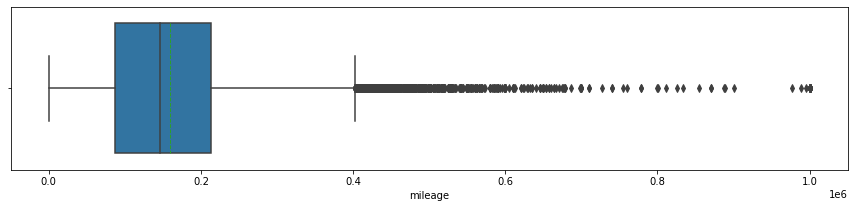

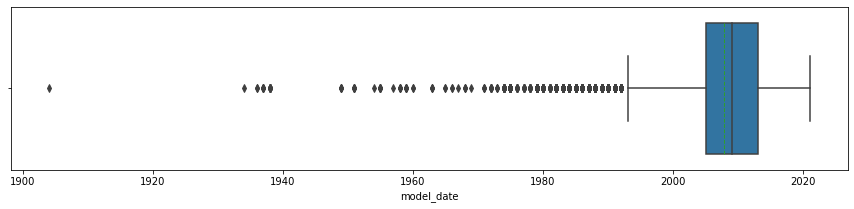

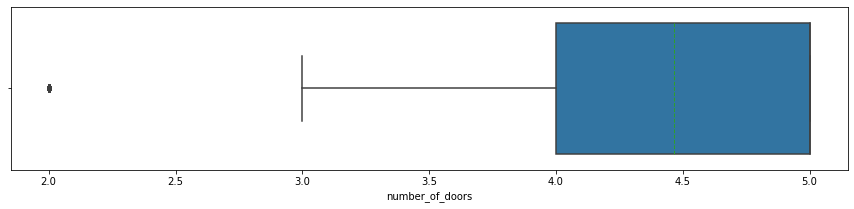

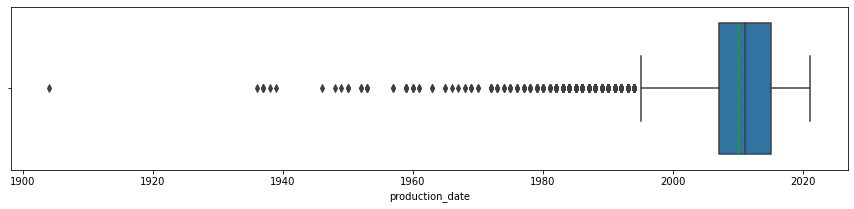

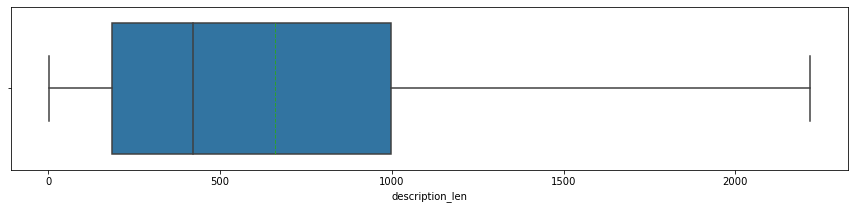

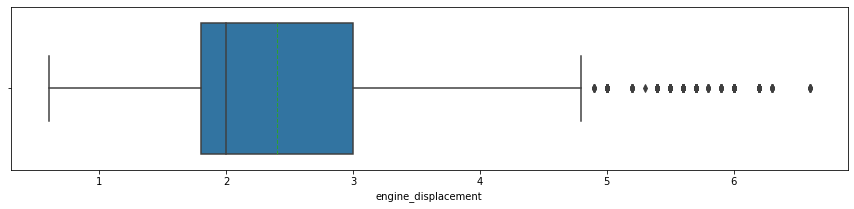

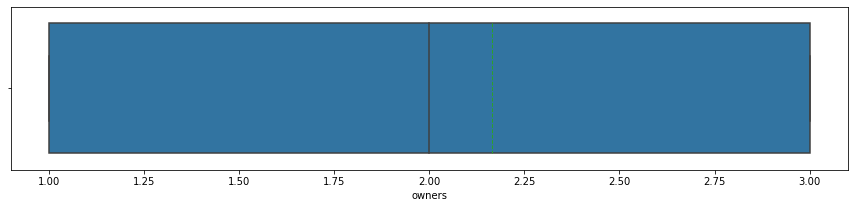

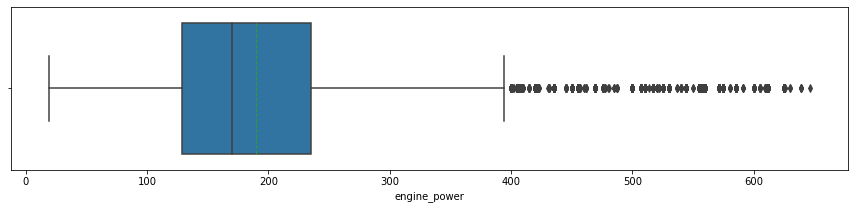

In [74]:
# Графики после преобразований
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(x = data[col],showmeans=True, meanline=True, orient='h')

Выбросы в определенной степени ограничены, не будет обрезать значения еще больше на данном этапе

In [75]:
# Обновленный список разделения признаков
bin_cols = ['customs', 'documents','drive_side','condition','retro']

cat_cols = ['body_type', 'brand', 'color',
            'fuel_type','model_name','vehicle_transmission','vendor', 'drive']

num_cols = ['mileage', 'model_date', 'number_of_doors', 'production_date','description_len', 
            'engine_displacement', 'owners', 'engine_power']

### Бинарные признаки

In [76]:
data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59717 entries, 0 to 59716
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customs     59714 non-null  object
 1   documents   59715 non-null  object
 2   drive_side  59717 non-null  object
 3   condition   59715 non-null  object
 4   retro       59717 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [77]:
# Заменим пропуски в признаке документов на оригинал, поскольку оригиналов значительно больше
data.documents.fillna('Оригинал', inplace=True)

In [78]:
data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59717 entries, 0 to 59716
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customs     59714 non-null  object
 1   documents   59717 non-null  object
 2   drive_side  59717 non-null  object
 3   condition   59715 non-null  object
 4   retro       59717 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


В тестовой выборке присутствуют только растаможенные машины, поэтому ограничим данные до только растаможенных

In [79]:
data = data[data.customs == 'Растаможен']

In [80]:
data.customs.value_counts()

Растаможен    59714
Name: customs, dtype: int64

В тестовой выборке присутствуют только машины, не требующие ремонта, поэтому ограничим данные до таких

In [81]:
data = data[data.condition == 'Не требует ремонта']

In [82]:
data.condition.value_counts()

Не требует ремонта    59712
Name: condition, dtype: int64

In [83]:
data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59712 entries, 0 to 59716
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customs     59712 non-null  object
 1   documents   59712 non-null  object
 2   drive_side  59712 non-null  object
 3   condition   59712 non-null  object
 4   retro       59712 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


In [84]:
# Удаляем из списка признаков таможню и состояние авто
bin_cols = ['documents','drive_side','retro']

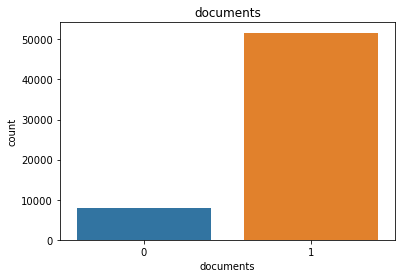

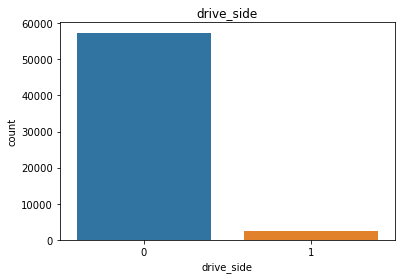

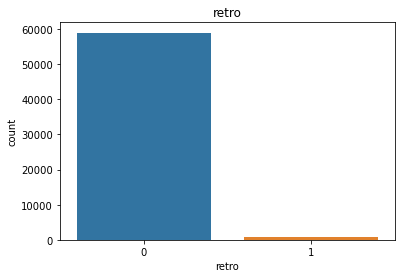

In [127]:
for i in bin_cols:
    sns.countplot(x = i, data = data)
    plt.title(i)
    plt.show()

Есть большая разница между значениями, но пока не будем никак на это влиять


In [86]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [128]:
# Проверим
data[bin_cols]

,documents,drive_side,retro
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
59712,1,0,0
59713,1,0,0
59714,1,0,0
59715,1,0,0


In [88]:
data[cat_cols + num_cols + bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59712 entries, 0 to 59716
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             59712 non-null  int64  
 1   brand                 59712 non-null  int64  
 2   color                 59712 non-null  int64  
 3   fuel_type             59712 non-null  int64  
 4   model_name            59712 non-null  int64  
 5   vehicle_transmission  59712 non-null  int64  
 6   vendor                59712 non-null  int64  
 7   drive                 59712 non-null  int64  
 8   mileage               59712 non-null  int64  
 9   model_date            59712 non-null  float64
 10  number_of_doors       59712 non-null  float64
 11  production_date       59712 non-null  float64
 12  description_len       59712 non-null  float64
 13  engine_displacement   59712 non-null  float64
 14  owners                59712 non-null  float64
 15  engine_power       

Признаки преобразованы для цифровой обработки

<AxesSubplot:>

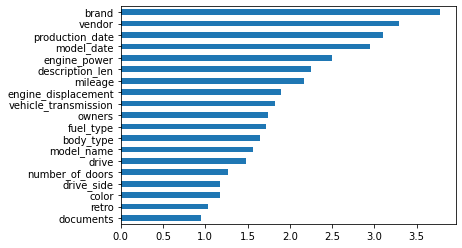

In [89]:
# Посмотрим на значимость всех переменных
imp_num = pd.Series(f_classif(data[cat_cols + num_cols + bin_cols], 
                              data['price'])[0], index = cat_cols + num_cols + bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Наибольшее значение на цену оказывают марка, регион производства а также год выпуска и модели. Влияет мощность двигателя, а также пробег. Количество слов в описании имеет немалое значение. Оставляем все признаки

In [94]:
data['price_log'] = data['price'].apply(lambda w: np.log(w + 1))

<Figure size 432x288 with 0 Axes>

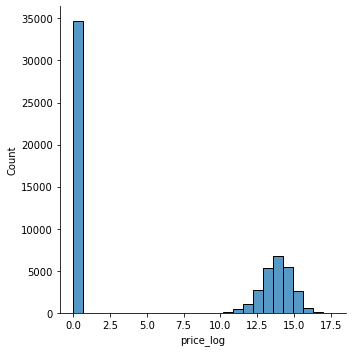

In [95]:
# Посмотрим на распределение цены после нормализации
plt.figure()
sns.displot(data.price_log, kde=False)

Логарифмирование привело график распределения цен к нормальному виду. Буду иметь в виду во время тестирования моделей

In [96]:
# Подвергнем нормализации длину комментариев, параметры двинателя
data['description_len'] = data['description_len'].apply(lambda w: np.log(w + 1))

<Figure size 432x288 with 0 Axes>

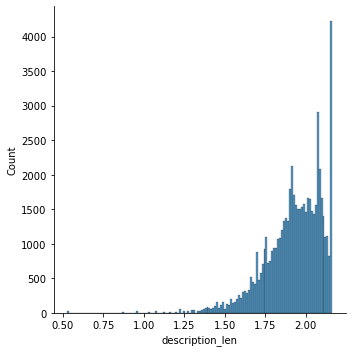

In [97]:
plt.figure()
sns.displot(data.description_len, kde=False)

In [98]:
data['engine_power'] = data['engine_power'].apply(lambda w: np.log(w + 1))

<Figure size 432x288 with 0 Axes>

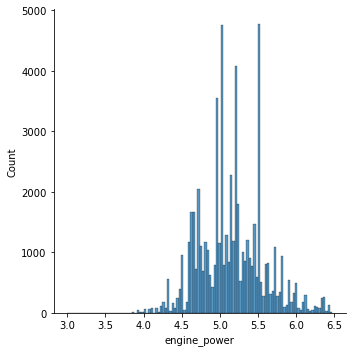

In [99]:
plt.figure()
sns.displot(data.engine_power, kde=False)

In [100]:
data['engine_displacement'] = data['engine_displacement'].apply(lambda w: np.log(w + 1))

<Figure size 432x288 with 0 Axes>

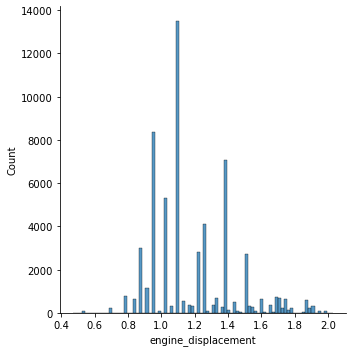

In [101]:
plt.figure()
sns.displot(data.engine_displacement, kde=False)

<AxesSubplot:>

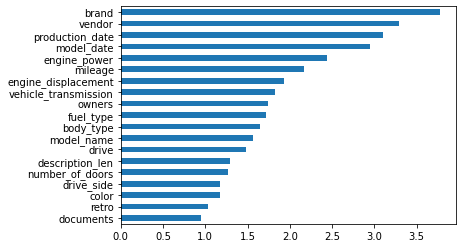

In [102]:
# Посмотрим на значимость всех переменных
imp_num = pd.Series(f_classif(data[cat_cols + num_cols + bin_cols], 
                              data['price'])[0], index = cat_cols + num_cols + bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Нормализация нескольких признаков привела к изменениям в приоретизации. 

In [103]:
# Обновленный список разделения признаков
bin_cols = ['documents','drive_side','retro']

cat_cols = ['body_type', 'brand', 'color',
            'fuel_type','model_name','vehicle_transmission','vendor', 'drive']
num_cols = ['mileage', 'model_date', 'number_of_doors', 'production_date','description_len', 
            'engine_displacement', 'owners', 'engine_power']  

In [104]:
# # Создадим список с колонками, которые присутствуют и в train, и в test
# cols_intersection = list(set(test.columns).intersection(data.columns))

# # Проверим, в каких колонках типы данных различаются у train и test
# cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
# print("Найдены расхождения в типах данных для:")

# for col in cols_intersection:
#     if type(test[col][0]) != type(data[col][0]):
#         print(
#             f"\t- колонки {col}: для data - {type(data[col][0])}, для test - {type(test[col][0])}")
#         cols_type_dif.append(col)

## Тесты моделей

In [118]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)

# Помещаем данные по типу в матрицу переменных
X_num = train_data[num_cols].values
X_bin = train_data[bin_cols].values
X_cat = train_data[cat_cols].values


# Объединяем три типа данных в одну матрицу значений Х
X = np.hstack([X_num, X_bin, X_cat,])
y = train_data['price'].values

# X = train_data.drop(['price'], axis=1)
# y = train_data['price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)


# Помещаем данные по типу в матрицу переменных
X_num_test = test_data[num_cols].values
X_bin_test = test_data[bin_cols].values
X_cat_test = test_data[cat_cols].values


X_test = np.hstack([X_num_test, X_bin_test, X_cat_test,])


### Линейная регрессия

In [108]:
# Обучаем модель
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказываем на валидационной выборке
y_pred_val = linear_model.predict(X_val)

# оцениваем точность
print(
    f"Точность модели по метрике MAPE: {(mape(y_val, y_pred_val))*100:0.2f}%")

Точность модели по метрике MAPE: 113.14%


In [109]:
# Нормализируем параметры, используя RobustScaler, можно использовать StandardScaler
scaler=RobustScaler()

X_train_robust = scaler.fit_transform(X_train)
X_val_robust = scaler.transform(X_val)

# Обучаем модель на тестовом наборе данных
linear_robust = LinearRegression().fit(X_train_robust, y_train)
# Предсказанные значения записываем в переменную y_pred
y_pred_val = linear_robust.predict(X_val_robust)

# Сравниваем предсказанные значения (y_pred) с валидационными (y_val), и смотрим насколько 
# они в среднем отличаются
print(
    f"Точность модели по метрике MAPE: {(mape(y_val, y_pred_val))*100:0.2f}%")

Точность модели по метрике MAPE: 113.14%


### Random forest

In [110]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Предсказанные значения записываем в переменную
y_default_pred_val = rf.predict(X_val)

#Вычисляем MAPE:
print(
    f"Точность модели по метрике MAPE: {(mape(y_val, y_default_pred_val))*100:0.2f}%")

Точность модели по метрике MAPE: 17.97%


In [132]:
# # Зададим сетку гиперпараметров, которые будут перебираться:

# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [131]:
# # Обучим наш лес:

# rf = RandomForestRegressor(random_state=42)
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                                cv=3, verbose=2, random_state=42, n_jobs=-1)
# rf_random.fit(X_train, y_train)

In [133]:
# rf_random.best_params_

In [111]:
rf_2 = RandomForestRegressor(random_state = 42, 
                           n_jobs = -1, 
                           verbose = 1,
                           n_estimators= 400,
                           min_samples_split= 2,
                           min_samples_leaf= 1,
                           max_features= 'sqrt',
                           max_depth= None,
                           bootstrap= False)
                          
                          
rf_2.fit(X_train, y_train)

y_pred_val_2 = rf.predict(X_val)



#Вычисляем MAPE:
print(f"Точность модели по метрике MAPE: {(mape(y_val, y_pred_val_2)) * 100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.6s


Точность модели по метрике MAPE: 17.97%


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.4s finished


### Gradient Boosting

In [112]:
# Создаем модель с параметрами по умолчанию
baseline_gradient = GradientBoostingRegressor(learning_rate=0.1, 
                                   n_estimators=2000,
                                   max_depth=5, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   subsample=1,
                                   random_state=42,
                                   max_features=None)

# Обучаем модель
baseline_gradient.fit(X_train, y_train)

# Предсказываем
y_pred_base = baseline_gradient.predict(X_val)

# Вычисляем MAPE:
print(f"Точность модели по метрике MAPE: {(mape(y_val, y_pred_base)) * 100:0.2f}%")

Точность модели по метрике MAPE: 16.68%


In [1422]:
# # Зададим сетку гиперпараметров, которые будут перебираться:

# # from sklearn.model_selection import GridSearchCV

# param_grid = {'learning_rate':[0.01, 0.03, 0.1], 
#               'n_estimators':[1750, 2000, 2500]
#              }

# gbr = GradientBoostingRegressor(random_state=42,
#                                 subsample=1,
#                                 max_depth=5,
#                                 min_samples_leaf=1,
#                                 min_samples_split=2,
#                                 max_features=None)
                            
# gbr_grid = GridSearchCV(estimator=gbr, param_grid=param_grid,
#                         scoring='neg_mean_absolute_error',
#                         n_jobs=-1,
#                         cv=5)
# gbr_grid.fit(X_train, y_train)

In [1423]:
# # Посмотрим на оптимальные гиперпараметры
# gbr_grid.best_params_

{'learning_rate': 0.03, 'n_estimators': 2500}

In [1427]:
# Улучшим модель 
updated_gradient = GradientBoostingRegressor(learning_rate=0.03, 
                                   n_estimators=2500,
                                   max_depth=5, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   subsample=1,
                                   random_state=42,
                                   max_features=None)

# Обучаем модель
updated_gradient.fit(X_train, y_train)

# Предсказываем
y_pred_base = updated_gradient.predict(X_val)

# Вычисляем MAPE:
print(f"Точность модели по метрике MAPE: {(mape(y_val, y_pred_base)) * 100:0.2f}%")

Точность модели по метрике MAPE: 16.52%


### CatBoost

In [120]:
cbr = CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
cbr.fit(X_train, y_train,
         eval_set=(X_val, y_val),
         verbose_eval=0,
         use_best_model=True,
         )

# Предсказываем
y_pred_cbr = cbr.predict(X_val)

# Вычисляем MAPE:
print(f"Точность модели по метрике MAPE: {(mape(y_val, y_pred_cbr)) * 100:0.2f}%")

Точность модели по метрике MAPE: 16.42%


### XG Boost

In [ ]:
# xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                       colsample_bytree=0.5, 
#                       learning_rate=0.03, 
#                       max_depth=12, 
#                       alpha=1, 
#                       n_jobs=-1, 
#                       n_estimators=1000)

# xgb.fit(X_train, y_train+1)
# VERSION = 7

# y_predict_xgb = xgb.predict(X_val)

# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

### Stacking

In [122]:
# Выберем модели 
estimators = [('rfr', RandomForestRegressor(random_state=42
                      , n_estimators=400
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False)),
              ('etr', ExtraTreesRegressor(random_state = 42))]

st_ensemble_1 = StackingRegressor(estimators=estimators, 
                                  final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val, predict_ensemble_1))*100:0.2f}%")

Точность модели по метрике MAPE: 14.50%


In [1463]:
predict_ensemble_1

array([ 268853.00468486, 2484709.19777333, 3103179.90647545, ...,
        616639.73670068,  623132.31430549,  502765.6236712 ])

In [125]:
# Изменим параметры
estimators = [('etr', ExtraTreesRegressor(random_state = 42)),
              ('rfr', RandomForestRegressor(random_state=42
                      , n_estimators=400
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False))]

st_ensemble_2 = StackingRegressor(estimators=estimators, 
                                  final_estimator=RandomForestRegressor())

# оцениваем точность
st_ensemble_2.fit(X_train, np.log(y_train))
predict_ensemble_2 = np.exp(st_ensemble_2.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val, predict_ensemble_2))*100:0.2f}%")

Точность модели по метрике MAPE: 16.67%


In [1457]:
# Изменим параметры
estimators = [('etr', ExtraTreesRegressor(random_state = 42)),
              ('rfr', RandomForestRegressor(random_state=42
                      , n_estimators=400
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False))]

st_ensemble_3 = StackingRegressor(estimators=estimators, 
                                  final_estimator=CatBoostRegressor())

# оцениваем точность
st_ensemble_3.fit(X_train, np.log(y_train))
predict_ensemble_3 = np.exp(st_ensemble_3.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val, predict_ensemble_3))*100:0.2f}%")

Learning rate set to 0.066537
0:	learn: 0.9487584	total: 1.25ms	remaining: 1.25s
1:	learn: 0.8925017	total: 2.53ms	remaining: 1.26s
2:	learn: 0.8403401	total: 3.68ms	remaining: 1.22s
3:	learn: 0.7921523	total: 4.82ms	remaining: 1.2s
4:	learn: 0.7468721	total: 5.98ms	remaining: 1.19s
5:	learn: 0.7046418	total: 7.12ms	remaining: 1.18s
6:	learn: 0.6662000	total: 8.24ms	remaining: 1.17s
7:	learn: 0.6297159	total: 9.42ms	remaining: 1.17s
8:	learn: 0.5956947	total: 10.5ms	remaining: 1.15s
9:	learn: 0.5645238	total: 11.6ms	remaining: 1.15s
10:	learn: 0.5352202	total: 12.9ms	remaining: 1.16s
11:	learn: 0.5082504	total: 14.1ms	remaining: 1.16s
12:	learn: 0.4828731	total: 15.2ms	remaining: 1.15s
13:	learn: 0.4597594	total: 16.3ms	remaining: 1.15s
14:	learn: 0.4387178	total: 17.5ms	remaining: 1.15s
15:	learn: 0.4190155	total: 18.7ms	remaining: 1.15s
16:	learn: 0.4007952	total: 19.8ms	remaining: 1.14s
17:	learn: 0.3839139	total: 21ms	remaining: 1.15s
18:	learn: 0.3684873	total: 22.1ms	remaining: 1

160:	learn: 0.2194647	total: 190ms	remaining: 988ms
161:	learn: 0.2194473	total: 191ms	remaining: 986ms
162:	learn: 0.2194021	total: 192ms	remaining: 987ms
163:	learn: 0.2193620	total: 194ms	remaining: 987ms
164:	learn: 0.2193348	total: 195ms	remaining: 985ms
165:	learn: 0.2193043	total: 196ms	remaining: 983ms
166:	learn: 0.2192841	total: 197ms	remaining: 981ms
167:	learn: 0.2192385	total: 199ms	remaining: 986ms
168:	learn: 0.2192036	total: 200ms	remaining: 984ms
169:	learn: 0.2191814	total: 201ms	remaining: 983ms
170:	learn: 0.2191607	total: 203ms	remaining: 982ms
171:	learn: 0.2191123	total: 204ms	remaining: 981ms
172:	learn: 0.2190887	total: 205ms	remaining: 980ms
173:	learn: 0.2190506	total: 206ms	remaining: 979ms
174:	learn: 0.2190033	total: 208ms	remaining: 979ms
175:	learn: 0.2189817	total: 209ms	remaining: 979ms
176:	learn: 0.2189456	total: 210ms	remaining: 978ms
177:	learn: 0.2189120	total: 212ms	remaining: 978ms
178:	learn: 0.2188642	total: 213ms	remaining: 977ms
179:	learn: 

461:	learn: 0.2130678	total: 573ms	remaining: 667ms
462:	learn: 0.2130477	total: 574ms	remaining: 666ms
463:	learn: 0.2130345	total: 576ms	remaining: 665ms
464:	learn: 0.2130253	total: 577ms	remaining: 664ms
465:	learn: 0.2129977	total: 578ms	remaining: 663ms
466:	learn: 0.2129797	total: 580ms	remaining: 661ms
467:	learn: 0.2129729	total: 583ms	remaining: 663ms
468:	learn: 0.2129568	total: 585ms	remaining: 662ms
469:	learn: 0.2129473	total: 586ms	remaining: 661ms
470:	learn: 0.2129433	total: 587ms	remaining: 659ms
471:	learn: 0.2129352	total: 589ms	remaining: 658ms
472:	learn: 0.2129250	total: 590ms	remaining: 657ms
473:	learn: 0.2129155	total: 591ms	remaining: 656ms
474:	learn: 0.2129052	total: 593ms	remaining: 655ms
475:	learn: 0.2128833	total: 594ms	remaining: 654ms
476:	learn: 0.2128562	total: 595ms	remaining: 653ms
477:	learn: 0.2128336	total: 597ms	remaining: 652ms
478:	learn: 0.2128192	total: 598ms	remaining: 650ms
479:	learn: 0.2128087	total: 599ms	remaining: 649ms
480:	learn: 

751:	learn: 0.2092345	total: 961ms	remaining: 317ms
752:	learn: 0.2092135	total: 962ms	remaining: 316ms
753:	learn: 0.2092045	total: 964ms	remaining: 314ms
754:	learn: 0.2091998	total: 965ms	remaining: 313ms
755:	learn: 0.2091837	total: 966ms	remaining: 312ms
756:	learn: 0.2091730	total: 967ms	remaining: 310ms
757:	learn: 0.2091556	total: 968ms	remaining: 309ms
758:	learn: 0.2091439	total: 970ms	remaining: 308ms
759:	learn: 0.2091404	total: 971ms	remaining: 307ms
760:	learn: 0.2091334	total: 972ms	remaining: 305ms
761:	learn: 0.2091187	total: 973ms	remaining: 304ms
762:	learn: 0.2091087	total: 974ms	remaining: 303ms
763:	learn: 0.2090995	total: 975ms	remaining: 301ms
764:	learn: 0.2090947	total: 976ms	remaining: 300ms
765:	learn: 0.2090813	total: 978ms	remaining: 299ms
766:	learn: 0.2090664	total: 979ms	remaining: 297ms
767:	learn: 0.2090628	total: 980ms	remaining: 296ms
768:	learn: 0.2090564	total: 981ms	remaining: 295ms
769:	learn: 0.2090410	total: 982ms	remaining: 293ms
770:	learn: 

Точность модели по метрике MAPE: 14.80%


In [1458]:
# Изменим параметры
estimators = [('etr', ExtraTreesRegressor(random_state = 42)),
              ('gbr', GradientBoostingRegressor(learning_rate=0.1, 
                                   n_estimators=2000,
                                   max_depth=5, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   subsample=1,
                                   random_state=42,
                                   max_features=None))]

st_ensemble_4 = StackingRegressor(estimators=estimators, 
                                  final_estimator=RandomForestRegressor())

# оцениваем точность
st_ensemble_4.fit(X_train, np.log(y_train))
predict_ensemble_4 = np.exp(st_ensemble_4.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val, predict_ensemble_4))*100:0.2f}%")

Точность модели по метрике MAPE: 15.96%


## Обработка тестовых данных и предсказание для соревнования

In [1854]:
# Стандартизируем
# scaler = StandardScaler()
# X_test[:,:len(num_cols)] = scaler.fit_transform(X_test[:,:len(num_cols)]) 

In [1695]:
# Выберем модель 
estimators = [('rfr', RandomForestRegressor(random_state=42
                      , n_estimators=400
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False)),
              ('etr', ExtraTreesRegressor(random_state = 42))]

st_ensemble_1 = StackingRegressor(estimators=estimators, 
                                  final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val, predict_ensemble_1))*100:0.2f}%")

Точность модели по метрике MAPE: 14.48%


In [1470]:
predict_ensemble_1_test = np.exp(st_ensemble_1.predict(X_test))

In [1471]:
predict_ensemble_1_test

array([1838498.1044213 , 3649872.2426403 , 2447855.6781209 , ...,
        705179.17570418, 3534360.78111441, 1373474.53091444])

In [114]:
sample_submission = pd.read_csv('sample_submission.csv')

In [1483]:
predict_submission = predict_ensemble_1_test
VERSION = 1
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,1838498.0
1,1100549428,3649872.0
2,1100658222,2447856.0
3,1100937408,2341252.0
4,1101037972,2292653.0


In [1479]:
# Предсказываем
y_pred_cbl = cbl.predict(X_test)

In [1480]:
y_pred_cbl

array([4191572.36877455, 7753749.93326294, 4799505.86116576, ...,
       3006166.39157851, 5463858.68512894, 3294453.06356319])

In [1482]:
predict_submission = y_pred_cbl
VERSION = 2
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,4191572.0
1,1100549428,7753750.0
2,1100658222,4799506.0
3,1100937408,4046016.0
4,1101037972,4130900.0


In [1484]:
predict_submission = rf.predict(X_test)
VERSION = 3
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.1s finished


,sell_id,price
0,1100575026,3446218.0
1,1100549428,7787187.0
2,1100658222,5246374.0
3,1100937408,4179546.0
4,1101037972,5050240.0


In [1486]:
predict_submission = rf.predict(X_test)
VERSION = 4
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.1s finished


,sell_id,price
0,1100575026,6824496.0
1,1100549428,6794423.0
2,1100658222,6861552.0
3,1100937408,6177236.0
4,1101037972,6205969.0


In [1487]:
predict_submission = y_pred_cbl
VERSION = 5
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,4191572.0
1,1100549428,7753750.0
2,1100658222,4799506.0
3,1100937408,4046016.0
4,1101037972,4130900.0


In [1718]:
predict_submission = rf.predict(X_test)
VERSION = 6
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.2s finished


,sell_id,price
0,1100575026,812950.0
1,1100549428,1215434.0
2,1100658222,1124597.0
3,1100937408,876585.0
4,1101037972,912686.0


In [1982]:
predict_submission = rf.predict(X_test)
VERSION = 7
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,806369.0
1,1100549428,1223249.0
2,1100658222,1135120.0
3,1100937408,907200.0
4,1101037972,919391.0


In [1742]:
predict_submission = cbr.predict(X_test)
VERSION = 8
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,879364.0
1,1100549428,1212880.0
2,1100658222,1240469.0
3,1100937408,923133.0
4,1101037972,1126296.0


In [1744]:
predict_submission = cbr.predict(X_test)
VERSION = 9
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,879364.0
1,1100549428,1212880.0
2,1100658222,1240469.0
3,1100937408,923133.0
4,1101037972,1126296.0


In [1975]:
predict_submission = rf_2.predict(X_test)
VERSION = 8
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.2s finished


,sell_id,price
0,1100575026,812950.0
1,1100549428,1215434.0
2,1100658222,1124597.0
3,1100937408,876585.0
4,1101037972,912686.0


In [2185]:
predict_submission = rf.predict(X_test)
VERSION = 9
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,620117.0
1,1100549428,1051019.0
2,1100658222,838467.0
3,1100937408,797939.0
4,1101037972,824791.0


In [119]:
predict_submission = baseline_gradient.predict(X_test)
VERSION = 10
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,554807.0
1,1100549428,637444.0
2,1100658222,886570.0
3,1100937408,672042.0
4,1101037972,1040953.0


In [121]:
predict_submission = cbr.predict(X_test)
VERSION = 11
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,536949.0
1,1100549428,776017.0
2,1100658222,766818.0
3,1100937408,621728.0
4,1101037972,847212.0


In [124]:
predict_submission = np.exp(st_ensemble_1.predict(X_test))
VERSION = 12
sample_submission['price'] = np.round(predict_submission)
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,572221.0
1,1100549428,879374.0
2,1100658222,824287.0
3,1100937408,691647.0
4,1101037972,646365.0


После экперементов я выбрал stacking Random Forest Regressor, Extra Tree Regressor и Linear Regression в качестве оконательного эстиматора